# Figure 2

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr


In [5]:
def load_expansion_data(path_to_boot = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/expansionSimulation/data/bootmarch")->pd.DataFrame:

    lo_boots = np.array(os.listdir(path_to_boot))
    lo_boots = np.sort(lo_boots.astype(int))
    lo_boots = lo_boots[0:-2]
    lo_boot_paths = [f'{path_to_boot}/{boot}' for boot in lo_boots]
    lo_egads = os.listdir("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/expansionSimulation/data/bootmarch/1/EGAD")

    lo_egads_paths = [f'{boot_path}/EGAD/{egad}' for boot_path in lo_boot_paths for egad in lo_egads]
    lo_dfs = [pd.read_csv(path) for path in lo_egads_paths]
    # Get metadata
    lo_ncts_for_df = [string.split("/")[-1].split("_")[0] for string in lo_egads_paths]
    lo_boots_for_df = [string.split("/")[-3] for string in lo_egads_paths]
    
    # Add metadata to each df
    def add_metadata(lo_dfs, lo_ncts_for_df, lo_boots_for_df) -> list:
        lo_dfs_meta = []
        for i, df in enumerate(lo_dfs):
            nct = lo_ncts_for_df[i]
            boot = lo_boots_for_df[i]
            
            # print(nct)
            # print(boot)
            df['nct'] = nct
            df['boot'] = boot
            
            lo_dfs_meta.append(df)
        return lo_dfs_meta
    lo_dfs_meta = add_metadata(lo_dfs=lo_dfs,
                               lo_ncts_for_df=lo_ncts_for_df,
                               lo_boots_for_df=lo_boots_for_df)
    
    def concat_dfs(lo_dfs_meta) -> pd.DataFrame:
        all_dfs_concat = pd.concat(lo_dfs_meta, axis = 0)
        all_dfs_concat = all_dfs_concat.reset_index()
        graph_dfs = all_dfs_concat.groupby(['nct', 'index'])['auc'].mean().reset_index()
        graph_dfs['nct'] = pd.to_numeric(graph_dfs['nct'])
        graph_dfs.sort_values('nct', ascending=True).nct.unique()
        return graph_dfs
    
    graph_dfs = concat_dfs(lo_dfs_meta=lo_dfs_meta)
    
    def load_metadata(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv")->pd.DataFrame:
        GO_curations = pd.read_csv(path, sep = "\t").loc[:,['id', 'CTAffiliated']]
        return GO_curations
    
    GO_curations = load_metadata()
    
    # Combine metadata with performance
    graph_with_meta = graph_dfs.merge(GO_curations, left_on='index', right_on = 'id')
        
    return graph_with_meta
        
graph_dfs_mean_cta = load_expansion_data()
graph_dfs_mean_cta.head()

,nct,index,auc,id,CTAffiliated
0,10,GO:0000045,0.527025,GO:0000045,F
1,15,GO:0000045,0.525773,GO:0000045,F
2,20,GO:0000045,0.535164,GO:0000045,F
3,25,GO:0000045,0.516493,GO:0000045,F
4,30,GO:0000045,0.531437,GO:0000045,F


## Stats

## General linear model

In [6]:
def fit_model_expansion(graph_dfs_mean_cta:pd.DataFrame):    
    model = smf.ols('auc ~ nct*CTAffiliated + log*CTAffiliated', data=graph_dfs_mean_cta).fit()
    return model

graph_dfs_mean_cta['log'] = np.log(graph_dfs_mean_cta['nct'])

model_expansion = fit_model_expansion(graph_dfs_mean_cta=graph_dfs_mean_cta)
model_expansion.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     622.8
Date:                Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:47:29   Log-Likelihood:                 30544.
No. Observations:               23732   AIC:                        -6.108e+04
Df Residuals:                   23726   BIC:                        -6.103e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4997      0.005    110.367      0.000       0.491       0.509
CTAffiliated[T.T]        -0.0262      0.008     -3.326      0.001      -0.042      -0.011
nct                    -1.27e-06   6.14e-05     -0.021      0.984      -0.000       0.000
nct:CTAffiliated[T.T]    -0.0002      0.000     -1.926      0.054      -0.000    3.59e-06
log                       0.0206      0.002     10.595      0.000       0.017       0.024
log:CTAffiliated[T.T]     0.0184      0.003      5.416      0.000       0.012       0.025
==============================================================================
Omnibus:                     2070.311   Durbin-Watson:                   0.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3119.211
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
model_expansion.pvalues

Intercept                0.000000e+00
CTAffiliated[T.T]        8.826096e-04
nct                      9.835016e-01
nct:CTAffiliated[T.T]    5.405722e-02
log                      3.582612e-26
log:CTAffiliated[T.T]    6.145078e-08
dtype: float64

In [8]:
graph_dfs_mean_cta_grouped = graph_dfs_mean_cta.groupby(['nct', 'CTAffiliated'])['auc'].mean().reset_index()
graph_dfs_mean_cta_grouped['log'] = np.log(graph_dfs_mean_cta_grouped['nct'])
graph_dfs_mean_cta_grouped['prediction'] = model_expansion.predict(graph_dfs_mean_cta_grouped)

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


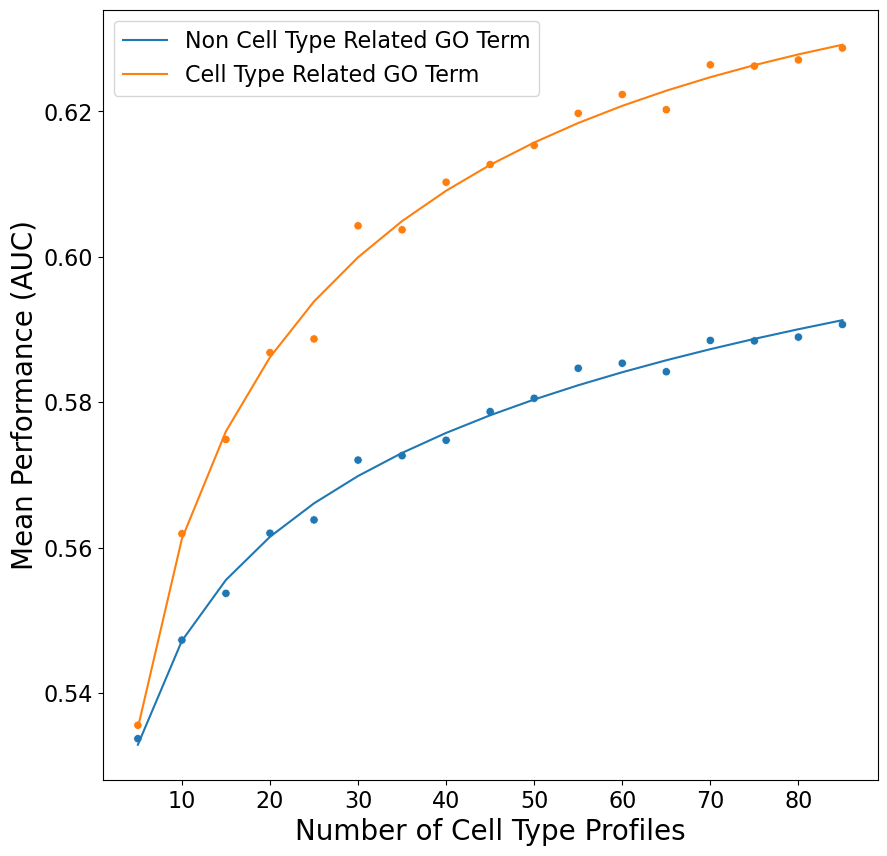

In [9]:
def plot_lineplot(graph_dfs_mean_cta_grouped):
    # Set the figure size
    plt.figure(figsize=(10,10))  # Adjust width and height as needed

    graph_dfs_mean_cta_grouped['CTAffiliated'] = graph_dfs_mean_cta_grouped['CTAffiliated'].replace({"T":"Cell Type Related GO Term", "F":"Non Cell Type Related GO Term"})
    # Plot the lineplot
    sns.lineplot(data=graph_dfs_mean_cta_grouped, x="nct", y='prediction', hue="CTAffiliated", )

    # Plot the boxplot
    sns.scatterplot(data=graph_dfs_mean_cta_grouped, x="nct", y='auc', hue="CTAffiliated", legend=False )

    # Set title and labels
    # plt.title("Positive Relationship Between Performance \n and Cell Type Profile Breadth", fontsize=22)
    plt.xlabel("Number of Cell Type Profiles", fontsize=20)
    plt.ylabel("Mean Performance (AUC)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    legend = plt.legend(title="", fontsize=16, )  # Adjust title_fontsize here

    # Access the legend title and set font properties
    legend.get_title().set_fontsize(14)

    plt.savefig('final/performance_vs_ct_breadth.png', dpi=300, bbox_inches='tight')
    # Adjust layout to prevent cutoff
    # Show plot
    # plt.show()

plot_lineplot(graph_dfs_mean_cta_grouped=graph_dfs_mean_cta_grouped)

In [10]:
graph_dfs_mean_cta

,nct,index,auc,id,CTAffiliated,log
0,10,GO:0000045,0.527025,GO:0000045,F,2.302585
1,15,GO:0000045,0.525773,GO:0000045,F,2.708050
2,20,GO:0000045,0.535164,GO:0000045,F,2.995732
3,25,GO:0000045,0.516493,GO:0000045,F,3.218876
4,30,GO:0000045,0.531437,GO:0000045,F,3.401197
...,...,...,...,...,...,...
23727,65,GO:2001244,0.544594,GO:2001244,F,4.174387
23728,70,GO:2001244,0.545116,GO:2001244,F,4.248495
23729,75,GO:2001244,0.545653,GO:2001244,F,4.317488
23730,80,GO:2001244,0.560116,GO:2001244,F,4.382027


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


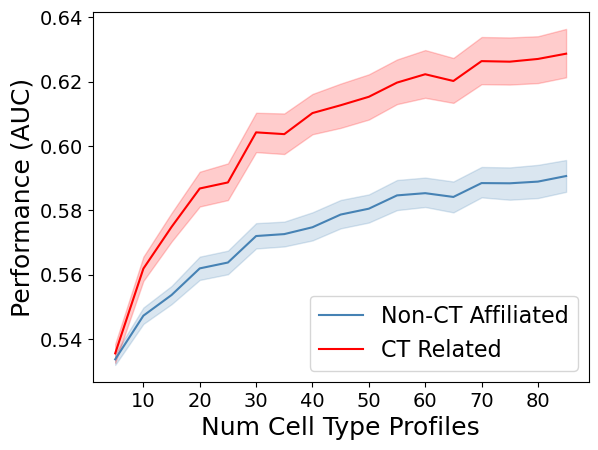

In [ ]:
def plot_error_expansion(graph_dfs_mean_cta):
    # Define custom colors for "T" and "F"
    custom_colors = {"T": "red", "F": "steelblue"}

    # Create a custom color palette
    palette = sns.color_palette([custom_colors.get(x, "#333333") for x in graph_dfs_mean_cta['CTAffiliated'].unique()])

    # Create a Seaborn line plot with 2 standard deviation error bars and custom colors
    sns.lineplot(data=graph_dfs_mean_cta, x='nct', y='auc', hue='CTAffiliated', palette=palette, errorbar='ci')

    # Add title and axis labels
    plt.xlabel('Num Cell Type Profiles',fontsize=18)
    plt.ylabel('Performance (AUC)', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # plt.title("Performance Increases When CT Profiles are Added")

    # Get legend
    legend = plt.legend(fontsize=16)

    # Update legend labels using the defined mapping
    for text in legend.texts:
        text.set_text('CT Related' if text.get_text() == 'T' else 'Non-CT Related')

    plt.savefig("final/expansion_line.png", dpi = 300,bbox_inches='tight')
    # Show the plot
    plt.show()
    
plot_error_expansion(graph_dfs_mean_cta=graph_dfs_mean_cta)


Compare to Simulated bulk brain performance

In [12]:
path_to_bootstrap_merged_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"
melted_results = pd.read_csv(path_to_bootstrap_merged_file,index_col=0)
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)
results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()
results=results[results.loc[:,'variance']==0.05]
results=results[results.loc[:,'exp_type']=="exp"]
results=results[results.loc[:,'tissue']=="brain"]
results['sc_auc'] = results['auc']
results = results.loc[:,['index', 'sc_auc']]
results

,index,sc_auc
6,GO:0000045,0.545295
14,GO:0000070,0.500938
22,GO:0000077,0.487778
30,GO:0000079,0.471284
38,GO:0000082,0.473454
...,...,...
11134,GO:2001237,0.474204
11142,GO:2001238,0.420278
11150,GO:2001240,0.477814
11158,GO:2001243,0.535729


In [13]:
brain_profile_df = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/simpleCTProfileEGAD/data/dev/0709/EGAD/brain_pro_EGAD.csv")
brain_profile_df['profile_auc']= brain_profile_df['auc']
brain_profile_df=brain_profile_df.merge(results, left_index=True, right_on='index')
# Calculate Spearman correlation
correlation, p_value = spearmanr(brain_profile_df['profile_auc'], brain_profile_df['sc_auc'])
print(correlation)

0.7432966592945429


In [14]:
path_to_bootstrap_merged_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bulkSimulationOneProfile/data/boot_run_feb29/master_melted_df.csv.gz"
melted_results = pd.read_csv(path_to_bootstrap_merged_file,index_col=0)
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)
results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()
results=results[results.loc[:,'variance']==0.05]
results=results[results.loc[:,'exp_type']=="exp"]
results=results[results.loc[:,'tissue']=="pbmc"]
results['sc_auc'] = results['auc']
results = results.loc[:,['index', 'sc_auc']]
results

,index,sc_auc
7,GO:0000045,0.561590
15,GO:0000070,0.574819
23,GO:0000077,0.525745
31,GO:0000079,0.517005
39,GO:0000082,0.516868
...,...,...
11135,GO:2001237,0.466306
11143,GO:2001238,0.497021
11151,GO:2001240,0.528088
11159,GO:2001243,0.509225


In [15]:
pbmc_profile_df = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/simpleCTProfileEGAD/data/dev/0709/EGAD/pbmc_pro_EGAD.csv")
pbmc_profile_df['profile_auc']= pbmc_profile_df['auc']
pbmc_profile_df=pbmc_profile_df.merge(results, left_index=True, right_on='index')
# Calculate Spearman correlation
correlation, p_value = spearmanr(pbmc_profile_df['profile_auc'], pbmc_profile_df['sc_auc'])
print(correlation)
print(p_value)

0.2461388250726488
1.036915330161581e-20


## B. CT Removal Experiment Rugplots

Read in GO Curations

In [28]:
GO_annots = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"
go_annot = pd.read_csv(GO_annots, sep = "\t")

Read in CT Removal Experiment


In [29]:
def load_ct_removal(tissue:str, path_to_boot:str)->pd.DataFrame:
    """Loads the ct removal experimental results in a dataframe for a given removal of a tissue (or cell type)

    Args:
        tissue (str): usually a cell type that has been removed in the ct removal experiment
        path_to_boot (str, optional): Path to ct removal experiment directory. Defaults to "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/ctRemovalExperiment/boot_100_0327":str.
    """
    def get_diff(merged):
        merged['diff']=merged['exp']-merged['cont']
        return merged
    def get_diff_deg(merged):
        merged['diff_deg']=merged['exp_deg']-merged['cont_deg']
        return merged
    lo_boots = np.array(os.listdir(path_to_boot), dtype=int)
    lo_boots = np.sort(lo_boots)[0:-1]
    lo_tissue_cont_paths = [f"{path_to_boot}/{boot}/EGAD/{tissue}_removed_control_EGAD.csv" for boot in lo_boots]
    lo_tissue_exp_paths = [f"{path_to_boot}/{boot}/EGAD/{tissue}_removed_experiment_EGAD.csv" for boot in lo_boots]
 
    lo_tissue_cont_dfs = [pd.read_csv(path) for path in lo_tissue_cont_paths]
    lo_tissue_exp_dfs = [pd.read_csv(path) for path in lo_tissue_exp_paths]
    
    lo_cont_with_boots = []
    for tissue_df, boot_value in zip(lo_tissue_cont_dfs, lo_boots):
        tissue_df['boot'] = boot_value
        lo_cont_with_boots.append(tissue_df)
    cont_boots = pd.concat(lo_cont_with_boots, axis = 0)
    
    lo_exp_with_boots = []
    for tissue_df, boot_value in zip(lo_tissue_exp_dfs, lo_boots):
        tissue_df['boot'] = boot_value
        lo_exp_with_boots.append(tissue_df)
    exp_boots = pd.concat(lo_exp_with_boots, axis = 0)
    
    exp_boots.rename(columns={'auc':'exp'}, inplace = True)
    cont_boots.rename(columns={'auc':'cont'}, inplace = True)
    
    exp_boots = exp_boots.reset_index()
    cont_boots = cont_boots.reset_index()
    
    merged = pd.merge(left = exp_boots, right = cont_boots, left_on = ['index', 'boot'], right_on = ['index', 'boot'])
    # print(merged.head())
    merged = merged.loc[:,['index', 'exp', 'degree_null_auc_x',  'cont', "degree_null_auc_y", 'boot']]

    
    merged.set_index('index', inplace = True)
    
    merged.rename(columns = {"degree_null_auc_x":'exp_deg',
                             "degree_null_auc_y":'cont_deg'}, inplace=True)
    merged = get_diff(merged=merged)
    merged = get_diff_deg(merged=merged)
    return merged

In [30]:
def get_con_exp_stats(merged:pd.DataFrame)->pd.DataFrame():
    """
    For each GO term, perform a paired t-test using the simulation bootstraps as instances

    Args:
        merged (pd.DataFrame): a melted dataframe containing performances of GO terms from this instance of a CT removal experiment

    Returns:
        pd.DataFrame: Dataframe with stats for each GO term
    """
    
    all_gos = merged.index.unique()

    lo_dfs = []
    for GO in all_gos:
        go_df = merged[merged.index == GO]

        
        # calculat effect size
        effect_size = go_df.loc[:,'diff'].mean()
        
        # Perform a paired t-test
        t_statistic, p_value = ttest_rel(go_df.loc[:,'cont'], go_df.loc[:,'exp'], alternative='greater')
        
        df_row = pd.DataFrame([{"GO":GO, 'pval':p_value, 't':t_statistic, 'effect':effect_size, 'cont':go_df['cont'].mean(), 'exp':go_df['exp'].mean(), 'exp_deg':go_df['exp_deg'].mean()}])
        lo_dfs.append(df_row)
        
    df_concat = pd.concat(lo_dfs, axis = 0)
    
    return df_concat

In [31]:
def add_metadata_to_stats(df_stats:pd.DataFrame, GO_curations:pd.DataFrame) -> pd.DataFrame:
    """Adds GO term metadata to the statistics

    Args:
        df_stats (df of stats for each GO term): df of stats for each GO term
        GO_curations (pd.DataFrame): Df of GO Curations
    Returns:
        pd.DataFrame: Stats with metadata
    """

    concat_meta = pd.merge(left = df_stats, right = GO_curations, left_on="GO", right_on='id')
    concat_with_meta = concat_meta.loc[:,['id', 'cont','exp','effect','exp_deg','pval','name', 'def', 'CTAffiliated','BrainAffiliated', 'PBMCAffiliated']]
    return concat_with_meta

In [32]:
# from scipy.stats import mannwhitneyu


# def wilcoxon_negpos(concat_with_meta, ct_affiliation_colname):
    
#     positive = concat_with_meta[concat_with_meta.loc[:,ct_affiliation_colname] == "T"]
#     negative = concat_with_meta[concat_with_meta.loc[:,ct_affiliation_colname] != "T"]
#     # Perform the Mann-Whitney U test
#     statistic, p_value = mannwhitneyu(positive.loc[:,'rank'], negative.loc[:,'rank'], alternative = 'less')

#     # Output the test statistic and p-value
#     print("Mann-Whitney U statistic:", statistic)
#     print("p-value:", p_value)
    
#     return p_value

In [33]:
def call_ct_related_go_terms(concat_with_meta:pd.DataFrame)->pd.DataFrame:
    """Add metadata about the ranks of our GO terms based on the statistics

    Args:
        concat_with_meta (pd.DataFrame): df of GO terms with T-stat scores

    Returns:
        pd.DataFrame: 
    """
    def make_r_rank(ranked_terms):
        """Helper function to get rank based on effect size"""
        ranked_terms = ranked_terms.sort_values('effect', ascending=False).reset_index(drop=True).reset_index()
        ranked_terms.rename(columns = {'index': 'r-rank'}, inplace=True)
        return ranked_terms
    def make_p_r_rank(ranked_terms):
        """Helper function to get rank based on pval"""

        ranked_terms = ranked_terms.sort_values('pval', ascending=False).reset_index(drop=True).reset_index()
        ranked_terms.rename(columns = {'index': 'r_pval_rank'}, inplace=True)
        return ranked_terms
    def make_deg_rrank(ranked_terms):
        """Helper function to get rank based on node degree"""
        ranked_terms = ranked_terms.sort_values('exp_deg', ascending=True).reset_index(drop=True).reset_index()
        ranked_terms.rename(columns = {'index': 'rank_exp_deg'}, inplace=True)
        return ranked_terms
    
    concat_with_meta = concat_with_meta.sort_values(by = 'effect')
    concat_with_meta = concat_with_meta.reset_index(drop = True)
    concat_with_meta['rank'] = concat_with_meta.index
    ranked_terms = concat_with_meta.copy()
    
    ranked_terms = make_r_rank(ranked_terms=ranked_terms)
    ranked_terms = make_p_r_rank(ranked_terms=ranked_terms)
    ranked_terms = make_deg_rrank(ranked_terms=ranked_terms)
    
    ranked_terms['logp']=np.log(ranked_terms.pval)
    ranked_terms.sort_values('effect', inplace=True)
    

    return ranked_terms


In [34]:
def get_ranked_terms(path_to_boot:str, tissue:str, GO_curations:pd.DataFrame)->tuple:
    """Wrapper function to do stats on a ct removal experiment and to get the top ranked terms


    Args:
        path_to_boot (str): path_to_ct removal directory
        tissue (str): current cell type that is removed
        GO_curations (pd.DataFrame): Df of GO curations

    Returns:
        pd.DataFrame: Dataframe that tells us what GO terms decrease the most when we remove this cell type
    """
    merged = load_ct_removal(path_to_boot=path_to_boot, tissue=tissue)
    df_stats = get_con_exp_stats(merged=merged)
    concat_with_meta = add_metadata_to_stats(df_stats = df_stats, GO_curations=GO_curations)
    ranked_terms = call_ct_related_go_terms(concat_with_meta=concat_with_meta)
    return concat_with_meta, ranked_terms

In [38]:
def rugplot(ranked_terms:pd.DataFrame, concat_with_meta:pd.DataFrame, tissue:str)->pd.DataFrame:
    """Wrapper function to create a rugplot for one cell type(tissue)

    Args:
        ranked_terms (pd.DataFrame): Dataframe of statistics for each GO term and rank metadata for it as well
        tissue (str): Tissue or Cell type for this CT Removal Experiment
    """
    def increase_bboxy(bbox):
        bbox.y0 = bbox.y0+0.04
        bbox.y1 = bbox.y1+0.04
        return bbox

    def make_rugplot_axes(bbox):
        bbox.y1 = bbox.y0+0.04
        return bbox


    def set_base_location(bbox):
        bbox.y0 = 0.125
        bbox.y1 = 0.875
        bbox.x0 = 0.125
        bbox.x1 = 0.875
        return bbox

    palette = sns.color_palette("Set2",3)

    # Create a figure and axes
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize = (6,5))

    ax1.set_position(set_base_location(ax1.get_position()))
    ax1.get_xaxis().set_ticks([]) 
    ax1.get_xaxis().set_visible(True)
    ax1.get_yaxis().set_visible(True)
    xlabel = ax1.set_xlabel("GO Terms", fontsize=16)
    xlabel.set_position((0.5, 1))


    ax2.set_position(ax1.get_position())
    ax2.set_position(make_rugplot_axes(ax2.get_position()))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    ax3.set_position(ax1.get_position())
    ax3.set_position(make_rugplot_axes(ax3.get_position()))
    ax3.set_position(increase_bboxy(ax3.get_position()))
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

    ax4.set_position(ax1.get_position())
    ax4.set_position(make_rugplot_axes(ax4.get_position()))
    ax4.set_position(increase_bboxy(increase_bboxy(ax4.get_position())))
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)


    # Create scatter plot without label
    col_to_sort_by = "logp" # effect, pval
    
    s = sns.scatterplot(data=ranked_terms.sort_values(col_to_sort_by), x='id', y=col_to_sort_by, s=5, label='', ax=ax1, color = 'black', alpha =1, edgecolor = None)

    # Add rug plot with green dots where 'BrainAffiliated' == 'T'
    r1 = sns.rugplot(data=concat_with_meta[concat_with_meta['BrainAffiliated'] == 'T'], x='id', color=palette[1], height=1, alpha=1, label='Brain GO Term', ax=ax3) # Use label='_nolegend_' to exclude from legend
    # ax2.get_xaxis().set_visible(False)

    # Add rug plot with red dots where 'PBMCAffiliated' == 'T'
    r2 = sns.rugplot(data=concat_with_meta[concat_with_meta['PBMCAffiliated'] == 'T'], x='id', color=palette[2], height=1, alpha=1, label='PBMC GO Term', ax=ax2) # Use label='_nolegend_' to exclude from legend


    r3 = sns.rugplot(data=concat_with_meta[concat_with_meta['CTAffiliated'] == 'F'], x='id', color=palette[0], height=1, alpha=0.5, label='Neither', ax=ax4) # Use label='_nolegend_' to exclude from legend

    # Make legend
    custom_lines = [Line2D([0], [0], color=palette[0], lw=4),
                    Line2D([0], [0], color=palette[1], lw=4),
                    Line2D([0], [0], color=palette[2], lw=4)]

    ax1.legend(custom_lines, ['Neither', 'Brain', 'PBMC'], title = 'GO Group', fontsize = 16, bbox_to_anchor=(0.95, 0.75),title_fontsize = 18)

    # Add title
    ax1.set_title(f"{tissue.replace('_',' ')}", fontsize='20')

    # Change y-axis title
    # Set the ylabel with the corrected LaTeX syntax and newline
    ax1.set_ylabel('Performance Change When Removed\n($\log_{p\;value}$)', fontsize=16)
    # Set xlabel with custom position


    fig.savefig(f"final/rugplots/{tissue}_rugplot.png",  bbox_inches='tight', dpi = 300)
    

Making rugplot for Excitatory_neurons


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Inhibitory_neurons


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Microglial_cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Astrocytes


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Oligodendrocytes


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Oligodendrocyte_precursor_cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for B-cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Dendritic_cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Macrophages


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Monocytes


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Nk-cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for Platelets


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Making rugplot for T-cells


/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


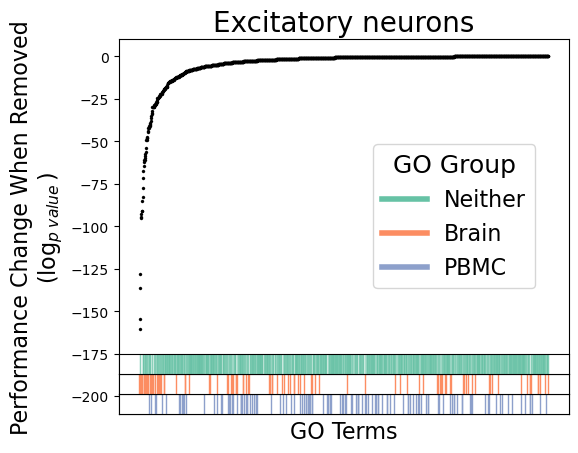

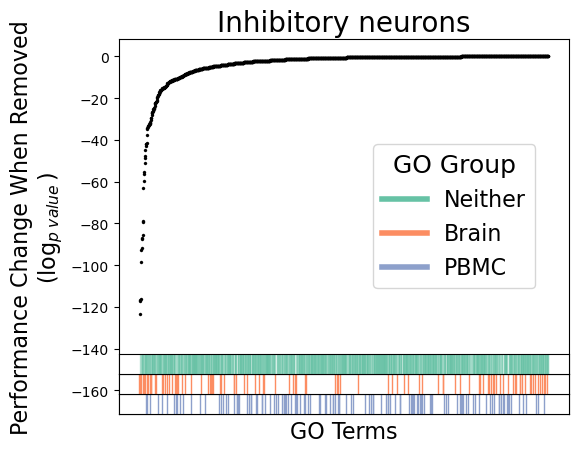

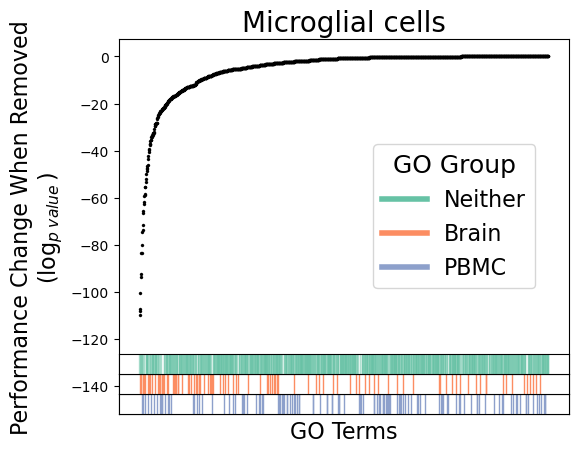

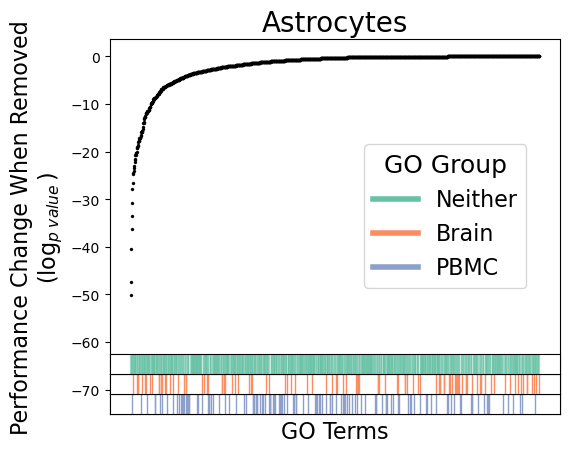

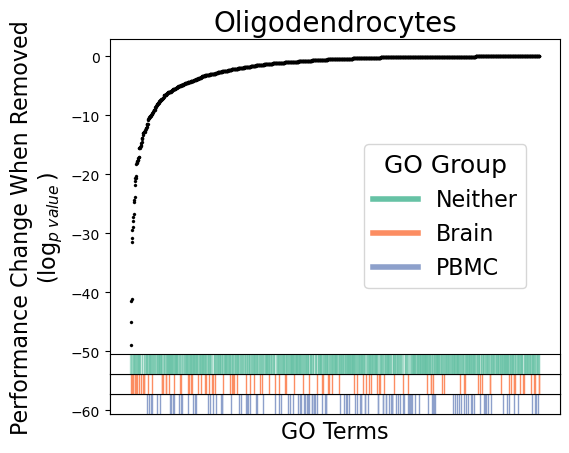

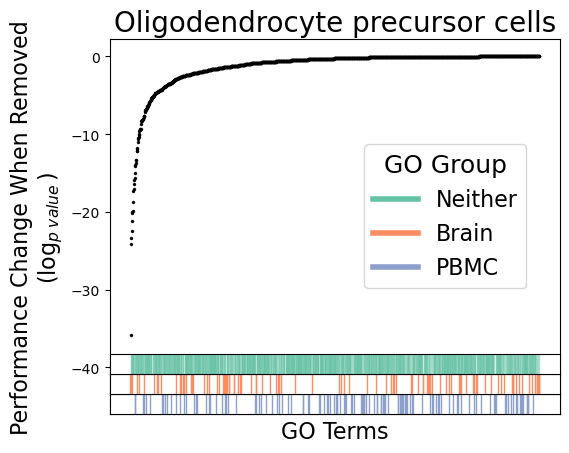

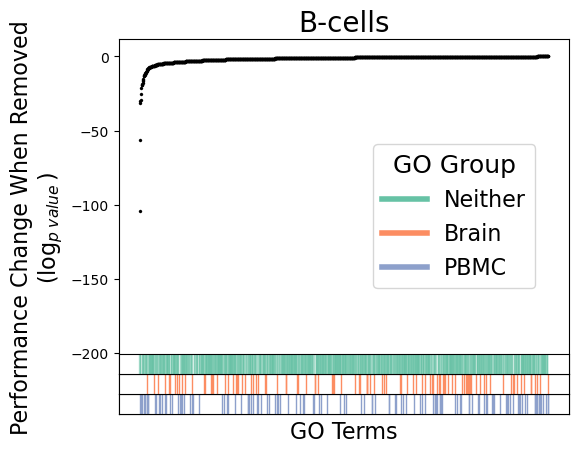

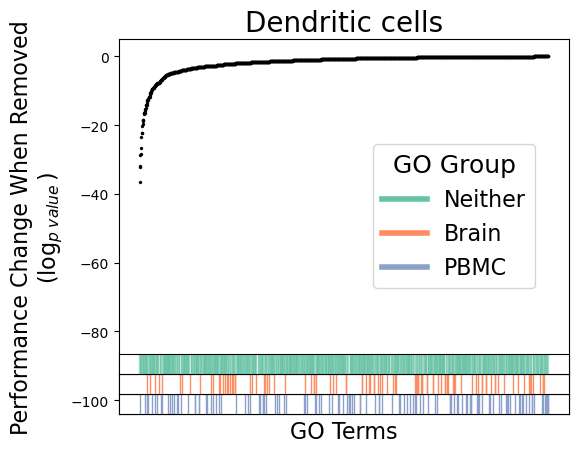

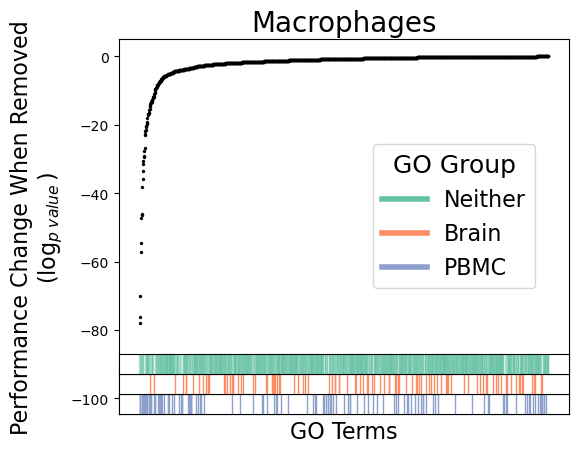

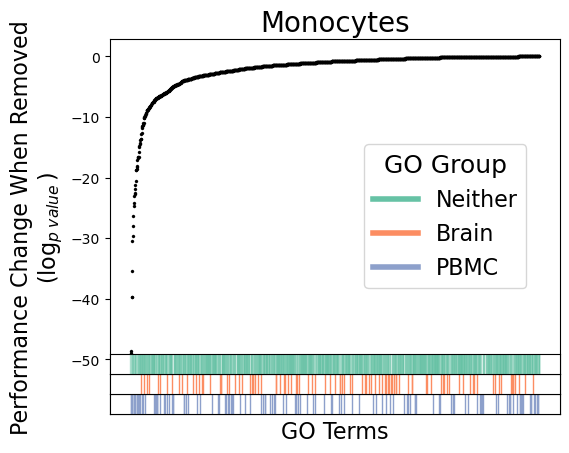

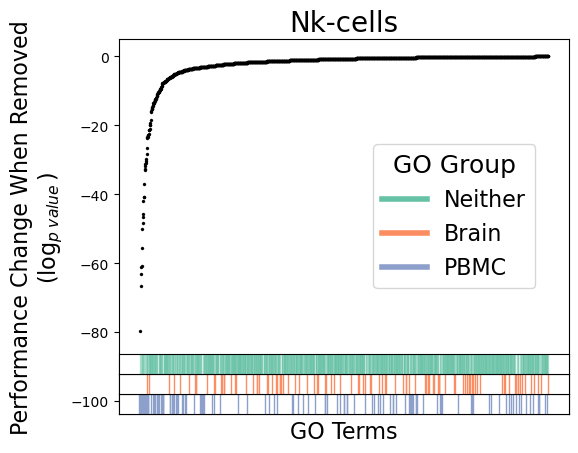

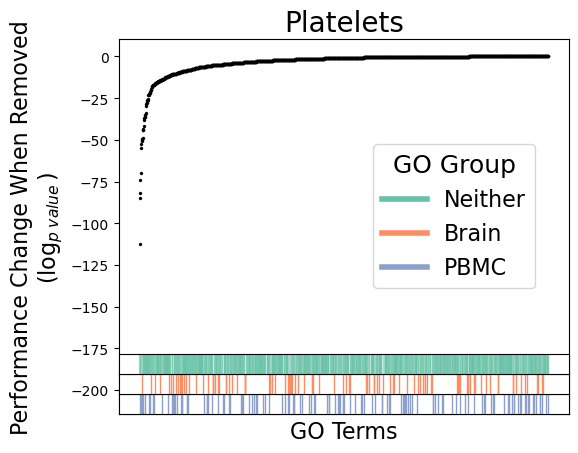

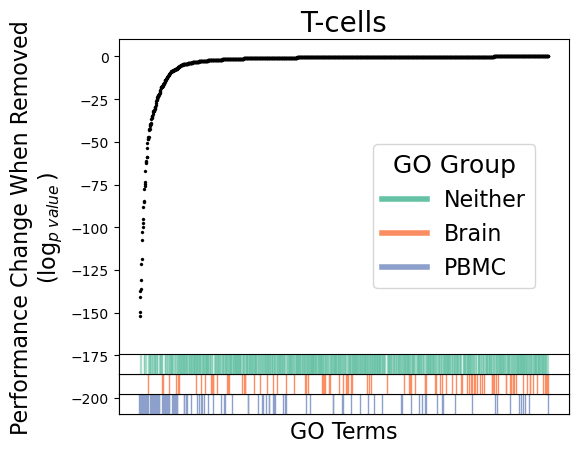

In [40]:
def make_rug_from_tissue(tissue:str,  GO_curations:pd.DataFrame, path_to_boot = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/ctRemovalExperiment/boot_100_0327")->None:
    """Makes a rugplot for one "tissue" which is one instance of a CT Removal experiment

    Args:
        tissue (str): Typically one cell type that has been removed from the matrix
        GO_curations (pd.DataFrame): Df of GO curations
        path_to_boot (str, optional): path to results. Defaults to "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/ctRemovalExperiment/boot_100_0327".
    """
    concat_with_meta, ranked_terms = get_ranked_terms(path_to_boot=path_to_boot,tissue=tissue,GO_curations=GO_curations)
    rugplot(ranked_terms=ranked_terms, tissue=tissue,concat_with_meta=concat_with_meta )

def make_rugplots_for_all():
    """
    Makes Rugplots for each CT Removal Experiment
    """
    # lo_cts = ['Excitatory_neurons',
    #       'Inhibitory_neurons',
    #       'Microglial_cells',
    #       'Astrocytes',
    #       'Oligodendrocytes',
    #       'Oligodendrocyte_precursor_cells',
    #       "B-cells",
    #       "Dendritic_cells",
    #       "Macrophages",
    #       "Monocytes",
    #       "Nk-cells",
    #       "Platelets",
    #       "T-cells"]
    # lo_cts = ['Excitatory_neurons']
    lo_cts = ['Excitatory_neurons',
        "T-cells"]
    
    def load_metadata(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv")->pd.DataFrame:
        GO_curations = pd.read_csv(path, sep = "\t")
        return GO_curations
    GO_curations = load_metadata()
    
    for tissue in lo_cts:
        print(f"Making rugplot for {tissue}")
        make_rug_from_tissue(tissue = tissue, GO_curations =GO_curations)
        
make_rugplots_for_all()

# AUROC Quantification and Plots

In [41]:
def make_auroc_for_go_aff(path_to_boot, lo_cts, label_col, predictor_col, cmap, stylemap, ax, GO_curations) -> dict:
    """Makes a ROC graph overaid for each ct.
    
    Also returns a dictionary where keys are ct from a ct removal experiment, and values are the AUC

    Args:
        path_to_boot (_type_): _description_
        lo_cts (_type_): _description_
        label_col (_type_): _description_
        predictor_col (_type_): _description_
        cmap (_type_): _description_
        stylemap (_type_): _description_
        ax (_type_): _description_
        GO_curations (_type_): _description_

    Returns:
        dict: _description_
    """
    
    def plot_auc(ranked_terms, predictor_colname, label_colname, color, ax, style, ct):
        # r-rank classification
        predicted_scores = ranked_terms[predictor_colname] 
        labels =  ranked_terms.loc[:,label_colname]=="T"
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(labels, predicted_scores)
        roc_auc = auc(x=fpr, y =tpr)
        ax.plot(fpr, tpr, color=color, lw=4, label=f"{ct}:{roc_auc.round(2)}", linestyle = style)
        
    def calc_auc(ranked_terms, predictor_colname, label_colname):
        # r-rank classification
        predicted_scores = ranked_terms[predictor_colname] 
        labels =  ranked_terms.loc[:,label_colname]=="T"
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(labels, predicted_scores)
        roc_auc = auc(x=fpr, y =tpr)
        return roc_auc
        
            
    # get the ranked calls for each cell type
    lo_ranked_dfs = []
    for ct in lo_cts:
        concat_with_meta, ranked_df =  get_ranked_terms(path_to_boot = path_to_boot, GO_curations=GO_curations, tissue = ct)
        lo_ranked_dfs.append(ranked_df)
    
    dic_aurocs = {}
    # get auroc for each ranked_df
    for i, ranked_df in enumerate(lo_ranked_dfs):
        ct = lo_cts[i]
        color = cmap.get(ct)
        style = stylemap.get(ct)
        
        # Plot ROC Curve on graph
        plot_auc(ranked_terms=ranked_df,
            predictor_colname=predictor_col,
            label_colname=label_col,
            color = color ,
            ax = ax,
            style = style,
            ct=ct)
        # Calc AUC
        roc_auc = calc_auc(ranked_terms=ranked_df,
            predictor_colname=predictor_col,
            label_colname=label_col)
        # Save AUC for Later
        dic_aurocs[ct] = roc_auc
        
        
    # Add diagonal
    ax.plot([0, 1], [0, 1], color='black', lw=4, linestyle='-',)
    ax.set_ylabel("True Positive Rate", fontsize=18)
    ax.set_xlabel("False Positive Rate", fontsize=18)
    # Axises and title
    # ax.set_title(f"Predicting {label_col}-Related Terms", fontsize=26)
    # Simplified way to set font size for both x and y tick labels
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontsize(16)

    ax.legend(bbox_to_anchor = (1.01, 0.95), title='AUROC', fontsize='16', title_fontsize='18')
    
    return dic_aurocs
        

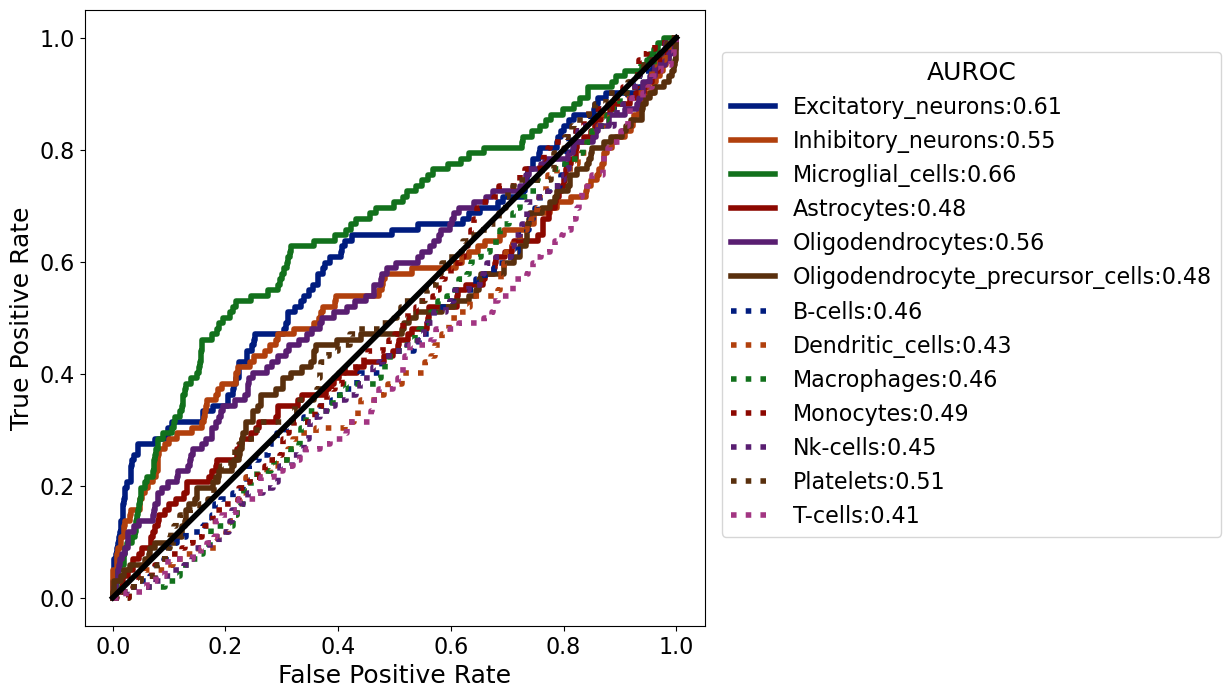

In [43]:
def make_auroc(label_col)->dict:
    """Make an AUROC graph for CT removal experiments, where we are trying to predict GO terms in label_col
    Also, returns AUROCfor each ct removal experiment
    Args:
        label_col (str): One of BrainAffiliated, PBMCAffiliated, CTAffiliated
    """
    def make_cmap():
        lo_brain_cts =  ['Excitatory_neurons',
            'Inhibitory_neurons',
            'Microglial_cells',
            'Astrocytes',
            'Oligodendrocytes',
            'Oligodendrocyte_precursor_cells']
        palette = sns.color_palette('dark')
        cmap_brain = dict(zip(lo_brain_cts,palette))
        
        lo_pbmc_cts =["B-cells",
            "Dendritic_cells",
            "Macrophages",
            "Monocytes",
            "Nk-cells",
            "Platelets",
            "T-cells"]
        palette = sns.color_palette('dark')
        cmap_pbmc = dict(zip(lo_pbmc_cts,palette))
        cmap_brain.update(cmap_pbmc)
        return cmap_brain

    def make_stylemap():
        lo_brain_cts =  ['Excitatory_neurons',
            'Inhibitory_neurons',
            'Microglial_cells',
            'Astrocytes',
            'Oligodendrocytes',
            'Oligodendrocyte_precursor_cells']
        style = "-"
        stylemap_brain = dict(zip(lo_brain_cts,np.repeat(style, len(lo_brain_cts))))
        
        lo_pbmc_cts =["B-cells",
            "Dendritic_cells",
            "Macrophages",
            "Monocytes",
            "Nk-cells",
            "Platelets",
            "T-cells"]
        style = ":"
        stylemap_pbmc = dict(zip(lo_pbmc_cts,np.repeat(style, len(lo_pbmc_cts))))
        stylemap_brain.update(stylemap_pbmc)
        return stylemap_brain
        
    
    lo_cts = ['Excitatory_neurons',
          'Inhibitory_neurons',
          'Microglial_cells',
          'Astrocytes',
          'Oligodendrocytes',
          'Oligodendrocyte_precursor_cells',
          "B-cells",
          "Dendritic_cells",
          "Macrophages",
          "Monocytes",
          "Nk-cells",
          "Platelets",
          "T-cells"]
    # lo_cts = ['Excitatory_neurons']

    cmap = make_cmap()
    stylemap = make_stylemap()
    
    
    def load_metadata(path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv")->pd.DataFrame:
        GO_curations = pd.read_csv(path, sep = "\t")
        return GO_curations
    
    GO_curations = load_metadata()

    fig, ax1 = plt.subplots(1,1, figsize = (8,8))
    
    dic_performance = make_auroc_for_go_aff(path_to_boot="/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/ctRemovalExperiment/boot_100_0327",
                        lo_cts = lo_cts,
                        label_col=label_col,
                        predictor_col='r_pval_rank',
                        cmap = cmap,
                        stylemap=stylemap,
                        ax=ax1,
                        GO_curations = GO_curations)
    
    fig.savefig(f"final/AUROC/AUROC_{label_col}.png", dpi=300, bbox_inches='tight',)
    return dic_performance
# Make plots for predicting PBMC affiliated GO term labels
# dic_pbmc_performance = make_auroc("PBMCAffiliated")
# Make plots for predicting Brain Affiliated GO term labels
dic_brain_performance = make_auroc("BrainAffiliated")


In [27]:
# Save AUC Dataframes
# df_pbmc_performance = pd.DataFrame(dic_pbmc_performance)
# df_pbmc_performance.to_csv("final/pbmc_auc.csv")

df_brain_performance = pd.DataFrame(dic_brain_performance)
df_brain_performance.to_csv("final/pbmc_brain.csv")


NameError: name 'dic_brain_performance' is not defined